In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import time

import cartopy.crs as ccrs

Background : The empirical p$^{th}$ percentile converges to the underying's dirstibution p$^{th}$ percentile asymptotically normally with standard deviation
$$\sigma = \sqrt{\dfrac{p(1-p)}{nf(x_p)^2}}$$

Where $f$ is the distribution's density function and $x_p$ the p$^{th}$ percentile. Here we estimate $f$ for TRMM daily precipitation at 0.25° (then different resolutions); and deduce the number of data points that would be needed to get the p$^{th}$ percentile to within 1% accuracy, with 95% confidence.

See https://en.wikipedia.org/wiki/Quantile#Estimating_quantiles_from_a_sample and https://minerve.ens-rennes.fr/images/Dev_TCL_quantile.pdf for a demonstration (in French) of that result

In [2]:
%matplotlib inline

In [3]:
trmmpr = xr.open_mfdataset(sorted(glob.glob("/Users/quentin.nicolas/Desktop/Berkeley/OrogExtremes/data/TRMM/3B42_Daily*")), combine="nested",concat_dim='time')


In [4]:
lsm=xr.open_dataset("/Users/quentin.nicolas/Desktop/Berkeley/OrogExtremes/data/ERA5Land_lsm.nc")
lsm.coords['longitude'] = (lsm.coords['longitude'] + 180) % 360 - 180
lsm = lsm.sortby(lsm.longitude)

In [5]:
tropicalpr = trmmpr.sel(lat=slice(-20.,20.)).precipitation
lsm2=lsm.lsm.rename({'longitude':'lon','latitude':'lat'}).interp_like(tropicalpr.isel(time=0)).isel(time=0).drop('time')


In [6]:
t=time.time()
test=np.array(tropicalpr)
print(time.time()-t)

11.22493290901184


In [7]:
#landtest=np.array()
testland = np.array(tropicalpr.where(lsm2>0.1))
testsea  = np.array(tropicalpr.where(lsm2<=0.1))

In [8]:
testlandf = testland.flatten()
testlandf=testlandf[~np.isnan(testlandf)]

testseaf = testsea.flatten()
testseaf=testseaf[~np.isnan(testseaf)]

In [9]:
tropicalpr2=xr.DataArray(test,coords=tropicalpr.coords,dims=["time","lon","lat"])

In [10]:
def plot_hist(ds):
    pdf,b,_=plt.hist(ds,bins=np.linspace(0.1,400,400),density=True)
    plt.yscale('log')
    bincenters=(b[:-1]+b[1:])/2.
    
    pct=99
    pctile=np.quantile(ds,pct/100)
    pdfpctile=pdf[np.argmin((bincenters-pctile)**2)]
    
    print("%i th percentile : %.1f mm/day"%(pct,pctile))
    print("Value of the PDF at that percentile : %.4f day/mm"%(pdfpctile))
    print("Number of data points needed to get this percentile within 1%% with 95%% confidence : %.2e"%((2/(0.01*pctile))**2 *pct/100*(1-pct/100)/pdfpctile**2) )
    
    

In [ ]:
print("My cross-eq domain's size : 60° lon x 140° lat = 5.25e6 4km grid cells, 1.46e5 24km grid cells")

99 th percentile : 54.8 mm/day
Value of the PDF at that percentile : 0.0011 day/mm
Number of data points needed to get this percentile within 1% with 95% confidence : 1.07e+05


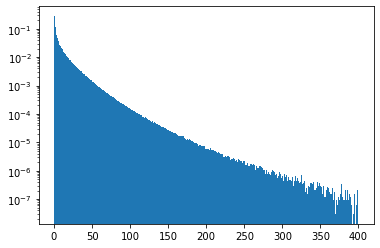

In [195]:
plot_hist(test.flatten())

99 th percentile : 49.6 mm/day
Value of the PDF at that percentile : 0.0015 day/mm
Number of data points needed to get this percentile within 1% with 95% confidence : 7.47e+04


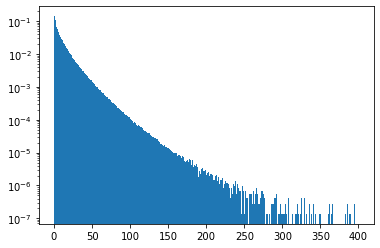

In [196]:
plot_hist(testlandf)

99 th percentile : 56.6 mm/day
Value of the PDF at that percentile : 0.0010 day/mm
Number of data points needed to get this percentile within 1% with 95% confidence : 1.22e+05


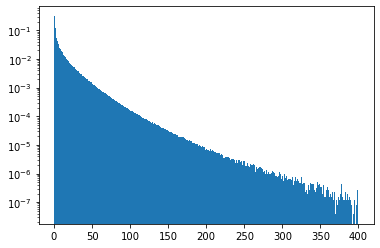

In [197]:
plot_hist(testseaf)

99 th percentile : 51.8 mm/day
Value of the PDF at that percentile : 0.0011 day/mm
Number of data points needed to get this percentile within 1% with 95% confidence : 1.28e+05


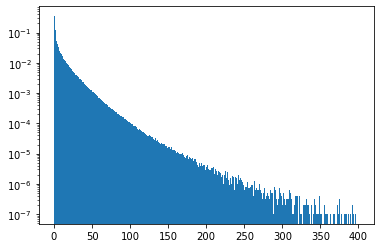

In [198]:
testcoarse=np.array(tropicalpr.coarsen(lat=2,lon=2, boundary="trim").mean())
plot_hist(testcoarse.flatten())

99 th percentile : 47.9 mm/day
Value of the PDF at that percentile : 0.0010 day/mm
Number of data points needed to get this percentile within 1% with 95% confidence : 1.63e+05


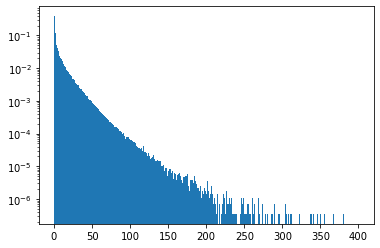

In [199]:
testcoarse=np.array(tropicalpr.coarsen(lat=4,lon=4, boundary="trim").mean())
plot_hist(testcoarse.flatten())

99 th percentile : 42.5 mm/day
Value of the PDF at that percentile : 0.0011 day/mm
Number of data points needed to get this percentile within 1% with 95% confidence : 1.76e+05


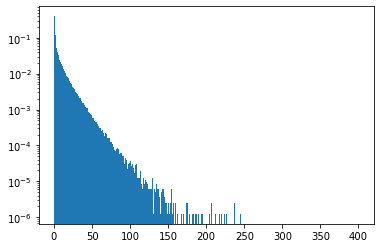

In [200]:
testcoarse=np.array(tropicalpr.coarsen(lat=8,lon=8, boundary="trim").mean())
plot_hist(testcoarse.flatten())

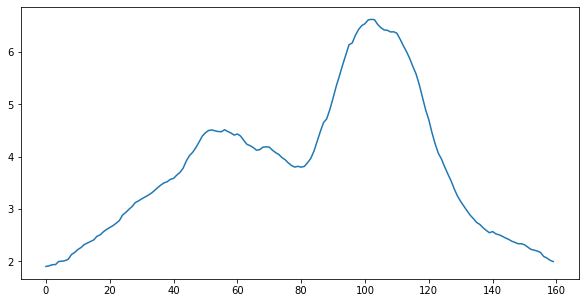

In [43]:
_,ax=plt.subplots(1,1,figsize=(10,5))
zonpr=tropicalpr2.mean(['time','lon'])
ax.plot(zonpr)
#tropicalpr2.mean(['time','lon']).plot(ax=ax,transform=ccrs.PlateCarree())
#ax.imshow(test.mean(axis=0).transpose())